Importing all necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import cv2
import glob
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

Function to import images and labels of needed Training or Test fruits.

In [5]:
def getFruits(fruits, set):
    images = []
    labels = []
        
    for i,f in enumerate(fruits):
        fruitFolder_path = "../fruits-360/" + set + "/" + f
        j=0
        for image_path in glob.glob(fruitFolder_path + "/*.jpg"):
            image = cv2.imread(image_path)   
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            b , g , r = cv2.split(image)
            images.append(image)
            labels.append(fruits[i])
            j+=1
        print("There are " , j, set, "images of " , fruits[i].upper())
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

Getting fruits training and test sets

In [6]:
training_images, training_labels = getFruits(["Apple Braeburn", "Apple Crimson Snow"],"Training")
test_images, test_labels = getFruits(["Apple Braeburn", "Apple Crimson Snow"],"Test")
print(np.shape(training_images[0]))

There are  492 Training images of  APPLE BRAEBURN
There are  444 Training images of  APPLE CRIMSON SNOW
There are  164 Test images of  APPLE BRAEBURN
There are  148 Test images of  APPLE CRIMSON SNOW
(100, 100, 3)


### - Function that grids pictures

In [7]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    n = 0
    if(nb_rows == 1 or nb_cols ==1):
            for i in range(0,nb_cols+nb_rows-1):
                axs[i].axis('off')
                axs[i].imshow(images[n])
                n += 1
    else:
        for i in range(0, nb_rows):
            for j in range(0, nb_cols):
                axs[i, j].axis('off')
                axs[i, j].imshow(images[n])
                n += 1

Grid of first 100 pictures of pineapples training set

Images of  Apple Braeburn


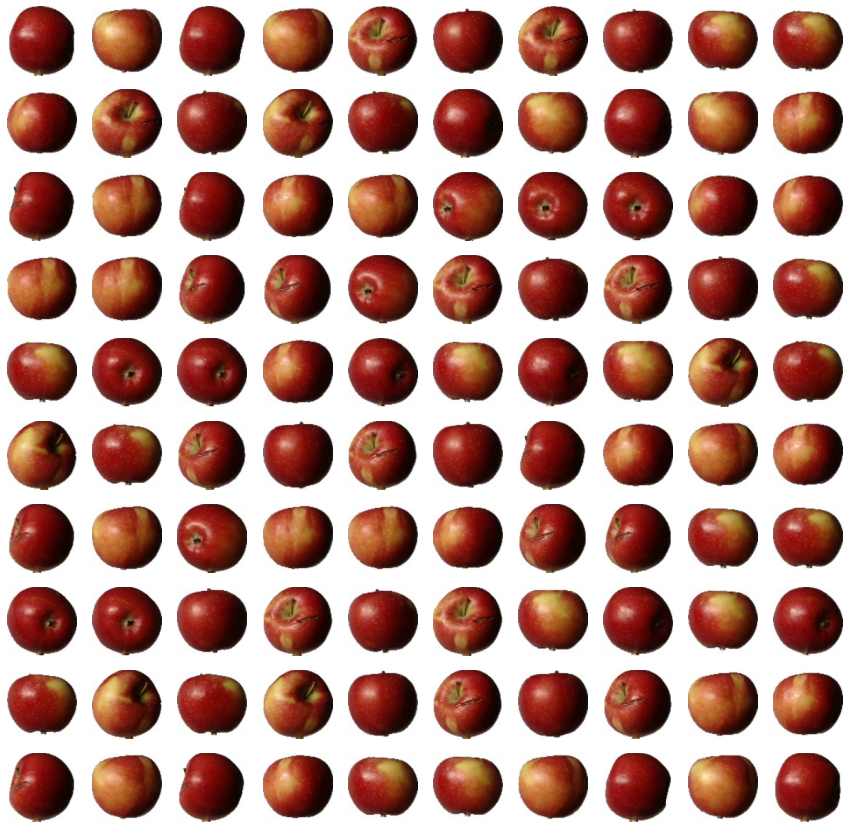

In [8]:
print("Images of ", training_labels[69])
plot_image_grid(training_images[0:100],10,10)

### Data transformation:
&emsp;&emsp;&emsp;&emsp; - Tranform RGB pics (100x100x3) to grayscale (100x100) <br>
&emsp;&emsp;&emsp;&emsp; - Linearizes each picture (100x100) into a linear array (10,000).

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in training_images])
X_test = scaler.fit_transform([i.flatten() for i in test_images])

### - PCA on grayscale images and scale it back to RGB

In [10]:
def performPCA(n, im_scaled):
    pca = PCA(n)
    principalComponents = pca.fit_transform(im_scaled) # 10,000 -> n
    reducedBWImages = pca.inverse_transform(principalComponents) # n -> 10,000
    reducedRGBImages = scaler.inverse_transform(reducedBWImages) # 10,000 -> 30,000
    return principalComponents, reducedBWImages, reducedRGBImages

In [14]:
#Compute PCA on train data for 2, 10, 50 PCs
train_principalComponents_2, train_reducedBWImages_2, train_reducedRGBImages_2 = performPCA(2, X_train)
train_principalComponents_10, train_reducedBWImages_10, train_reducedRGBImages_10 = performPCA(10, X_train)
train_principalComponents_50, train_reducedBWImages_50, train_reducedRGBImages_50 = performPCA(50, X_train)

#Compute PCA on test data for 2, 10, 50 PCs
test_principalComponents_2, test_reducedBWImages_2, test_reducedRGBImages_2 = performPCA(2, X_test)
test_principalComponents_10, test_reducedBWImages_10, test_reducedRGBImages_10 = performPCA(10, X_test)
test_principalComponents_50, test_reducedBWImages_50, test_reducedRGBImages_50 = performPCA(50, X_test)


### - Show PCA results on a sample image for 2, 10, 50 principal components

In [11]:
def showPCA(image,X2, X10, X50):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image)
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('50 PC')
    plt.imshow(X50)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('10 PC')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('2 PC')
    plt.imshow(X2)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


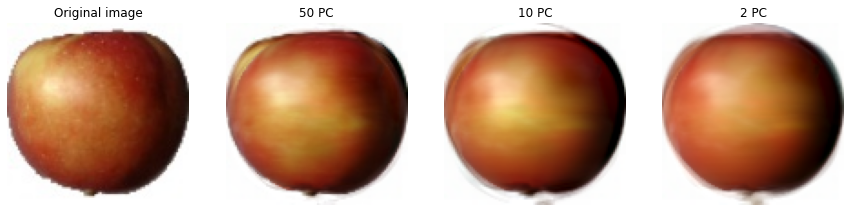

In [13]:
image_id = 1
image = training_images[image_id]

#Reshape in order to plot images
X2 = np.reshape(train_reducedRGBImages_2[image_id], (100,100,3)).astype(int)
X10 = np.reshape(train_reducedRGBImages_10[image_id], (100,100,3)).astype(int)
X50 = np.reshape(train_reducedRGBImages_50[image_id], (100,100,3)).astype(int)

showPCA(image, X2, X10, X50)

# SVM

Train and Test SVM using splitted training data. <br>
Probability = True, enables 5-fold cross validation.

In [21]:
svm = SVC(kernel="linear")
svm.fit(train_reducedBWImages_2,training_labels)
y_pred=svm.predict(test_reducedBWImages_2)


Evaluating SVM model

In [22]:
print(f"The model is {metrics.accuracy_score(y_pred,test_labels)*100}% accurate")

The model is 100.0% accurate


# KNN

Using 2 nearest neighbours

In [25]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(train_reducedBWImages_2, training_labels)
y_pred = knn.predict(test_reducedBWImages_2)

In [26]:
print(f"The model is {metrics.accuracy_score(y_pred,test_labels)*100}% accurate")

The model is 100.0% accurate


Using 10 nearest neighbours

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(f"The model is {metrics.accuracy_score(y_pred,y_test)*100}% accurate")

The model is 100.0% accurate


Using 500 nearest neighbours

In [ ]:
knn = KNeighborsClassifier(n_neighbors=500)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(f"The model is {metrics.accuracy_score(y_pred,y_test)*100}% accurate")

The model is 98.0% accurate


# DECISION TREES

Training decision tree mode; building the tree

In [ ]:
tree = DecisionTreeClassifier(max_depth=1)
tree = tree.fit(x_train,y_train)
y_pred = tree.predict(x_test)

Evaluation:

In [ ]:
print(f"The model is {metrics.accuracy_score(y_pred,y_test)*100}% accurate")

The model is 100.0% accurate
